In [1]:
!pip install tensorflow opencv-python-headless keras google-colab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 5.6 MB/s eta 0:00:00


In [2]:
from google.colab import output
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import cv2
import numpy as np
from keras.models import load_model
import PIL
import os
import matplotlib.pyplot as plt
from google.colab import drive

In [3]:
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getTracks()[0].stop();
      div.remove();

      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
age_model_path = '/content/drive/MyDrive/PROJELER/AgeGenDetect/Models/best_agemodel.keras'
gender_model_path = '/content/drive/MyDrive/PROJELER/AgeGenDetect/Models/best_gendermodel.keras'

age_model = load_model(age_model_path)
gender_model = load_model(gender_model_path)

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [8]:
filename = take_photo()
print('Saved to {}'.format(filename))

img = cv2.imread(filename)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

<IPython.core.display.Javascript object>

Saved to photo.jpg


1/1 [==============================] - 0s 18ms/step


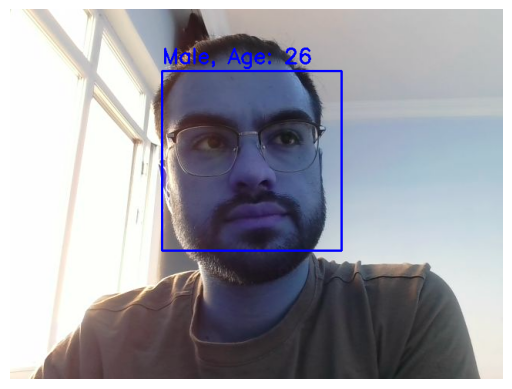

photo.jpg has been deleted.


In [9]:
def predict_age_and_gender(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x, y, w, h) in faces:
        face = img[y:y+h, x:x+w]
        face = cv2.resize(face, (128, 128))
        face = face / 255.0
        face = np.expand_dims(face, axis=0)

        age_prediction = age_model.predict(face)
        gender_prediction = gender_model.predict(face)

        age = int(age_prediction[0][0])
        gender = 'Male' if gender_prediction < 0.5 else 'Female'
        color = (255, 0, 0) if gender == 'Male' else (255, 192, 203)

        label = f'{gender}, Age: {age}'
        cv2.rectangle(img, (x, y), (x+w, y+h), color, 2)
        cv2.putText(img, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

    return img

result_img = predict_age_and_gender(img_rgb)

plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
os.remove(filename)
print(f'{filename} has been deleted.')